
# Connect to PhaLP and retrieve required data


import required packages, 
connect to MySQL database

In [11]:
import mysql.connector
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import os

# enter the correct variables for your locally installed MySQL server
user = 'phalp'
password = os.environ.get('PHALP_PWD')
host = 'localhost'
port = '3306'
db = 'phalp'
config = {'user': user, 'password': password, 'host': host, 'port': port, 'database': db}
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()
   



define 'read' and 'save' functions for joblib (alternative for pickle) and json

In [33]:
import joblib
import json


def read_pickle(name):
    with open(name, 'rb') as f:
        return joblib.load(f)
def save_pickle(d, name):
    with open(name, 'wb') as f:
        joblib.dump(d, f)
        
def read_json(name):
    with open(name, 'r') as f:
        return json.load(f)
def save_json(d, name):
    with open(name, 'w') as f:
        json.dump(d, f)

make dictionaries to map UniProt accessions to their Uniparc ID (UPI) and the other way around

In [13]:
select_accs = ("SELECT * FROM %s.UniProt;"%db)
cursor.execute(select_accs)
data = cursor.fetchall()

acc2upi = {}
upi2acc = {}

for row in data:
    acc2upi[row[0]]=row[5]
    if row[5] not in upi2acc.keys():
        upi2acc[row[5]]=[]
    upi2acc[row[5]].append(row[0])


Retrieve list of protein sequences (BioPython SeqRecords) from PhaLP and write to fasta

In [14]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

select_accs = ("SELECT * FROM %s.UniRef;"%db)
cursor.execute(select_accs)
data = cursor.fetchall()

c=0
sequences = []

for row in data:
    sequence = SeqRecord(Seq(row[3].decode("utf-8")), id=row[0])
    sequences.append(sequence)
    
with open('picklejar/sequences.fasta',"w") as handle:
    SeqIO.write(sequences, handle, "fasta")

    


Retrieve InterPro domain annotations for each protein from PhaLP

In [15]:
domacc2domname = {}
select_accs = ("SELECT * FROM %s.link_UniRef_domains as l join %s.domains as d where d.domains_ID = l.domains_ID;"%(db,db))
cursor.execute(select_accs)
data = cursor.fetchall()
c=0
upi2doms = {}
for row in data:
    if row[0] not in domacc2domname.keys():
         domacc2domname[row[0]]=  row[7]
    if row[1] not in upi2doms.keys():
        upi2doms[row[1]] = []
    upi2doms[row[1]].append(row[0])
    

   # Retrieve for each UniProt accesion, the annotations of all identical proteins (from the UniProt website) and process
   retrieving the annotations for each protein takes a while

In [283]:
def extract_identical_protein_annotations(df):
    all_loc = []
    all_func = []
    all_nam = []
    all_EC = []
    all_GO_id = []
    all_GO = []
    for loc in filter(lambda x : str(x)!='nan',df['Subcellular location [CC]'].tolist()):
        all_loc.extend([j.split(' {')[0].split(': ')[-1] for i in loc.split('SUBCELLULAR LOCATION: ')[1:] for j in i.split('.')[0].split('; ') ])
    for func in filter(lambda x : str(x)!='nan', df['Function [CC]'].tolist()):
        all_func.extend([i.split(' {')[0] for i in func[10:].split('; FUNCTION: ')])
    for GO_id in filter(lambda x : str(x)!='nan',df['Gene ontology IDs'].tolist()):
        all_GO_id.extend(GO_id.split('; '))
    for GO in filter(lambda x : str(x)!='nan',df['Gene ontology (GO)'].tolist()):
        all_GO.extend(GO.split('; '))
    for nam in [str(i) for i in filter(lambda x : str(x)!='nan',df['Protein names'].tolist())]:
        all_EC.extend(re.findall(r'\((EC.*?)\)',nam))
        all_nam.append(nam.split(' (')[0])
        all_nam.extend(list(filter(lambda x: x not in all_EC, re.findall(r'\((.*?)\)', nam))))
    locations = None
    functions = None
    names = None
    ECs = None
    GOs = None
    GO_ids = None
    
    # remove all duplicate entries in the list and order on frequency (most frequent first)
    if all_loc:
        locations = [i[0] for i in collections.Counter(all_loc).most_common()]
    if all_func:
        functions = [i[0] for i in collections.Counter(all_func).most_common()]
    if all_EC:
        ECs = [i[0] for i in collections.Counter(all_EC).most_common()]
    if all_nam:
        names = [i[0] for i in collections.Counter(all_nam).most_common()]
    if all_GO_id:
        GO_ids = [i[0] for i in collections.Counter(all_GO_id).most_common()]    
    if all_GO:
        GOs = [i[0] for i in collections.Counter(all_GO).most_common()]   
    return locations, functions, names, GO_ids, GOs, ECs

In [8]:
from concurrent.futures import as_completed, ProcessPoolExecutor,ThreadPoolExecutor
from requests_futures.sessions import FuturesSession
import urllib
from io import StringIO


upi2ann = {}
with FuturesSession(executor=ProcessPoolExecutor(max_workers=8)) as session:
    futures = [session.get('http://www.uniprot.org/uniprot/', params ={'query': 'uniparc:(%s)'%upi, 'format': 'tab','columns': 'comment(SUBCELLULAR LOCATION),comment(FUNCTION),protein names,go-id,go,id'}) for upi in list(upi2acc.keys()) if upi not in upi2ann.keys()]

    c=0        
    for future in as_completed(futures):
        if c%100 == 0:
            print(c,'/',len(upi2acc.keys()))
        c+=1
        while True:
            try:
                response = future.result()
                df = pd.read_csv(StringIO(response.text), sep="\t")
                upi = urllib.parse.parse_qs(urllib.parse.urlparse(response.url)[4])['query'][0][9:-1]
                locations, functions, names, GO_ids, GOs, ECs = extract_identical_protein_annotations(df)
                upi2ann[upi]={'locations':locations, 'functions':functions, 'names':names, 'GO_ids':GO_ids, 'GOs':GOs, 'ECs':ECs}
                break
            except (ConnectionError, pd.errors.ParserError, pd.errors.EmptyDataError) as err:
                print('ERROR:\t%s\t'%err)
                print(urllib.parse.parse_qs(urllib.parse.urlparse(response.url)[4])['query'][0][9:-1])

save_json(upi2ann, "picklejar/upi2ann.json")
            

0 / 7957
100 / 7957
200 / 7957
300 / 7957


KeyboardInterrupt: 

Process ForkProcess-5:
Process ForkProcess-8:
Process ForkProcess-6:
Process ForkProcess-4:
Process ForkProcess-2:
Process ForkProcess-3:
Process ForkProcess-7:
Process ForkProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/concurrent

In [8]:
upi2ann = read_json("picklejar/upi2ann.json")    

# Determine the PhaLP type based on  UniProt annotations

In [9]:
def determine_type(upi, ann, doms):   
    ip_locations, ip_functions, ip_names, ip_GO_ids, ip_GOs, ip_ECs =   [upi2ann[upi]['locations'], upi2ann[upi]['functions'], upi2ann[upi]['names'], upi2ann[upi]['GO_ids'], upi2ann[upi]['GOs'], upi2ann[upi]['ECs']]
    TYPE = None 
    source = None
    match = None
            
    if ip_locations:
        for loc in ip_locations:
            if  loc == 'Host cell inner membrane' or loc == 'Host cell wall' or loc == 'Secreted':
                TYPE='endolysin'
                source = 'UniProt location'
                match = loc
                break
            elif loc == 'Virion' or loc == 'Virion membrane':#!!!! P15 (P13559) of phage PRD1 is annotated as virion membrane protein but is in fact the endolysin
                TYPE='VAL'
                source = 'UniProt location'
                match = loc
                break
                        
                    
    if not TYPE and ip_functions:
        terms_endolysin = ['Essential for lysis of bacterial cell wall, by showing cell wall hydrolyzing activity.',
                            'The bacteriophage lysin is a powerful lytic agent',
                            'participates in the liberation of progeny bacteriophage',
                            'Helps to release the mature phage particles from the cell wall by breaking down the peptidoglycan',
                            'Endolysin that degrades host peptidoglycans'                   
                            ]
        for fun in ip_functions:
            m = re.search(r'|'.join(terms_endolysin),fun)
            if m:
                TYPE='endolysin'
                source = 'UniProt function'
                match = fun
                break   

                                
                                     
    if not TYPE and ip_GO_ids:
        for GO_id, GO in zip(ip_GO_ids, ip_GOs):
            if GO_id in ['GO:0044659', 'GO:0019076', 'GO:0051715','GO:0001897']:
                TYPE='endolysin'
                source = 'GO'
                match = GO
                break
            elif GO_id in ['GO:0098025', 'GO:0019062','GO:0007155','GO:0019012','GO:0055036','GO:0039641','GO:0098003','GO:0098015','GO:0039678','GO:0019867','GO:0099001','GO:0019069','GO:0043493','GO:0019073','GO:0098023','GO:0098004','GO:0044694']:
                TYPE='VAL'
                source = 'GO'
                match = GO
                break
        
    if not TYPE and doms:
        for dom in doms:
            if dom in ['cd16901','cd06415']:
                TYPE='endolysin'
                source = 'InterPro domain'
                match = dom + domacc2domname[dom]
                break
            elif dom in ['PF06715','SSF69349','SSF69255','G3DSA:2.40.50.260','PF06714','PF10145','TIGR02675','TIGR01760','PF06605','TIGR01665','SSF69279','PF06791','PF16838']:
                TYPE='VAL'
                source = 'InterPro domain'
                match = dom + domacc2domname[dom]
                break


    if not TYPE and ip_names:
        terms_VAPGH = ['tail','virion','capsid','core','head','injection','plate','tapemeasure','tape measure']
        terms_endolysin = ['endolysin','endolysiin','Lysin A']#,'lysin']#ply|lysA|lytic|lysis]


        for name in ip_names:
            if re.search(r'|'.join(terms_endolysin),name, re.IGNORECASE ) and not re.search(r'putative',name, re.IGNORECASE ):
                TYPE='endolysin'
                source = 'Protein name'
                match = name
                break
            elif re.search(r'|'.join(terms_VAPGH),name, re.IGNORECASE ) and not re.search(r'putative',name, re.IGNORECASE ):
                TYPE='VAL'
                source = 'Protein name'
                match = name
                break
    
    return TYPE, source, match

In [16]:
types = {'VAL':{},'endolysin':{},'None':{}}
upi2type = {}
upi2typesource = {}
upi2typematch = {}


for upi, ann in upi2ann.items():
    if upi in upi2doms.keys():
        doms = upi2doms[upi]
    else:
        doms = []
    TYPE , source, match = determine_type(upi, ann, doms )

    if not TYPE:
        TYPE='None'
    upi2type[upi] = TYPE
    upi2typesource[upi] = source
    upi2typematch[upi] = match

    types[TYPE][upi]=ann
c=0
for TYPE, upis in types.items():
    print(TYPE, len(upis))

VAL 1604
endolysin 2492
None 3861


# SeqVec features

bio-embeddings (v0.1.3) is used to embed all sequences with the SeqVec embedding model as described by Heinzinger et al (2019)

Run 'pip install bio-embeddings==0.1.3' in the terminal

The code is given in the cell below, but the actual embedding was done in a kaggle kernel, wich offers free GPU usage (NVIDIA TESLA P100). The kaggle notebook is available at https://www.kaggle.com/bjorncriel/phalp-seqvecembeddings.


In [ ]:
from bio_embeddings import SeqVecEmbedder


analyzed_upis = []
SeqVecEmbeddings = pd.DataFrame(columns=range(0,1024), index=[i.id for i in sequences] )

while len(analyzed_upis) < len(sequences):
    try:
        analyzed_upis = list(SeqVecEmbeddings.loc[pd.isnull(SeqVecEmbeddings).any(axis=1) == False].index)
        c = len(analyzed_upis)


        b= 100
        for i in range (0, len(sequences), b):
            seqs = [str(seq.seq) for seq in sequences[i:i+b] if seq.id not in analyzed_upis]
            seq_IDs = [seq.id for seq in sequences[i:i+b] if seq.id not in analyzed_upis]
            embeddings = [embedder.reduce_per_protein(e)  for e in embedder.embed_many(seqs)]


            d =0
            for embedding, seq_ID  in zip (embeddings,seq_IDs) :
                SeqVecEmbeddings.loc[seq_ID] = embedding
                d+=1
                c+=1
                if c%b == 0:
                    print(c, ' / ', len (sequences))
                    save_pickle(SeqVecEmbeddings,'SeqVecEmbeddings.pickle')
            print(i)
            
        save_pickle(SeqVecEmbeddings,'SeqVecEmbeddings.pickle')
        SeqVecEmbeddings.to_csv('SeqVecEmbeddings.csv')
        break
    except RuntimeError as err:
        save_pickle(SeqVecEmbeddings,'picklejar/SeqVecEmbeddings.pickle')
        print(seq.id, seq.seq, err)

In [76]:
#SeqVecEmbeddings=read_pickle('picklejar/SeqVecEmbeddings.pickle')
SeqVecEmbeddings = pd.read_csv('picklejar/SeqVecEmbeddings.csv', index_col = 0)

0       0.003362
1       0.017883
2       0.004867
3      -0.003960
4       0.011880
          ...   
1019   -0.032726
1020    0.004076
1021   -0.032452
1022    0.006338
1023    0.014956
Name: UPI000000153C, Length: 1024, dtype: float64

In [27]:

data= pd.DataFrame ( columns = ['upi','sequence','type'])
for sequence in sequences:
    new_row = {'upi':sequence.id,'sequence':str(sequence.seq),'type':upi2type[sequence.id]}
    data = data.append(new_row, ignore_index=True)
data = data.set_index('upi')



In [28]:
df = pd.concat([data, SeqVecEmbeddings], axis=1)# features_all
df.loc[pd.isnull(df).any(axis=1) == False]

,sequence,type,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
upi,,,,,,,,,,,,,,,,,,,,,
UPI000000153C,MAKVQFKPRATTEAIFVHCSATKPSQNVGVREIRQWHKEQGWLDVG...,endolysin,0.003362,0.017883,0.004867,-0.003960,0.011880,-0.109696,0.074875,-0.008234,...,0.022205,0.033710,0.046790,0.002778,0.029146,-0.032726,0.004076,-0.032452,0.006338,0.014956
UPI0000001D8C,MPENVPRSGLYYWPINPRKARPDVRYLDPDYYLGVKRPDGSWLVPP...,None,0.141772,0.042758,-0.270930,0.035103,0.141092,0.138736,0.004101,-0.032569,...,0.035081,-0.063396,0.083634,-0.165507,0.154086,-0.067843,-0.271620,0.027880,-0.054588,0.042903
UPI0000001D9D,MGRRTGAGGRGSWVLWALGALGVLALARAGASPARGGGGGTPGSGS...,None,0.040014,-0.063104,-0.093749,0.002234,0.071437,0.046191,-0.128621,0.162317,...,-0.005577,-0.027204,-0.046578,-0.064590,0.131056,-0.103302,-0.067298,-0.061918,-0.007506,-0.014846
UPI0000003A74,MQIKTKGDLVRAALRKLGVASDATLTDVEPQSMQDAVDDLEAMMAE...,VAL,-0.013268,-0.015605,0.000042,0.009797,0.039725,-0.059292,0.006509,-0.004938,...,0.069312,0.061290,0.049355,0.015452,0.007191,-0.030747,-0.006500,-0.079226,-0.011902,-0.000745
UPI0000003A96,MMQISSNGITRLKREEGERLKAYSDSRGIPTIGVGHTGKVDGNSVA...,endolysin,0.029104,-0.078329,-0.047752,-0.015629,0.006538,-0.036600,0.128124,0.004906,...,0.060797,0.040701,0.024016,-0.001906,-0.089612,-0.033198,0.005065,-0.026339,0.031327,0.067144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UPI00118CB198,MATFVFRDGSRLTPWMLYQINRLDAMLFALFGVHVIVTSGIRTYAE...,endolysin,-0.021432,-0.093799,0.028819,0.003774,-0.023384,-0.041585,0.025676,0.068821,...,0.049553,0.018458,0.060555,0.025501,0.077122,-0.014171,-0.032595,-0.013319,-0.079141,-0.037813
UPI00118CD35E,MANIEQYIFNVDADTSKAVSKLQQINKLMNQIDSIRGKGINEYFTT...,None,0.014277,-0.255489,-0.186098,0.053056,0.090267,0.052004,0.235841,-0.151788,...,0.080436,0.109630,-0.035354,0.117877,-0.154911,-0.184356,-0.030182,-0.126919,-0.045555,-0.210346
UPI0011983E4F,MTMTTLKAMALSVTFTIASGNVHASQNTSQCVYDFSEQQLNTLATA...,None,-0.058392,-0.101159,-0.012922,0.022722,0.005082,-0.116475,0.084039,-0.017378,...,0.093447,0.033491,0.068919,0.094651,-0.018512,-0.140398,-0.030203,0.048489,-0.028927,0.052897


In [30]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict, pos_label='endolysin')
    auc_score = metrics.auc(fpr, tpr)
    return fpr, tpr, auc_score

0.9843337819996624


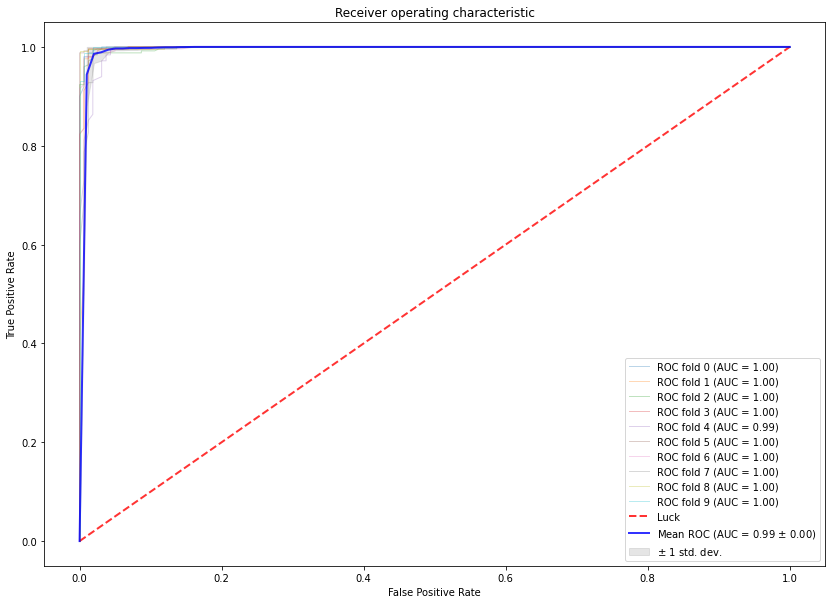

   AUC Train  AUC Test
0        1.0  0.999175
1        1.0  0.996325
2        1.0  0.997992
3        1.0  0.998042
4        1.0  0.994861
5        1.0  0.999738
6        1.0  0.998469
7        1.0  0.996034
8        1.0  0.999473
9        1.0  0.999423
64
Average F1:  0.9843385587563533


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, LeaveOneOut

df_known = df.loc[df['type']!='None']
df_unknown = df.loc[df['type']=='None']

X=df_known.drop(columns=['sequence','type'])
y=df_known['type']


clf = RandomForestClassifier(n_estimators=100 , class_weight = 'balanced')
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

KfoldCVpredictions = pd.DataFrame ( columns = ['upi','true_val', 'pred_val', 'pred_prob'])
fprs, tprs, scores, F1s = [], [], [] , []
c = 0
for (train, test) in cv.split(X, y):
    clf.fit(X.iloc[train], y.iloc[train])
    
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    df_test = y.iloc[test].to_frame().rename(columns={"type": "true_val"})
    df_test['pred_val']=clf.predict(X.iloc[test])
    df_test['pred_prob'] = [max(i) for i in clf.predict_proba(X.iloc[test])]
    F1s.append(metrics.f1_score(df_test['true_val'], df_test['pred_val'], average='weighted', labels=['VAL','endolysin']))
    
    for index, row in df_test.iterrows():
        pred_correct = True
        if row['true_val'] != row['pred_val']:
            pred_correct = False
            c+=1
        KfoldCVpredictions =  KfoldCVpredictions.append({'upi':index,'true_val':row['true_val'],'pred_val':row['pred_val'], 'pred_prob':row['pred_prob'],'pred_correct':pred_correct}, ignore_index=True)


            
            
print(np.average(F1s))
plot_roc_curve(fprs, tprs);
print(pd.DataFrame(scores, columns=['AUC Train', 'AUC Test']))
print(c)

#KfoldCVpredictions['pred_val_correct'] = KfoldCVpredictions['pred_val'].map(lambda x: x[0])#
#KfoldCVpredictions['true_val_correct'] = KfoldCVpredictions['true_val'].map(lambda x: x.iloc[0])
print('Average F1: ', metrics.f1_score(KfoldCVpredictions['true_val'], KfoldCVpredictions['pred_val'], average='weighted', labels=['VAL','endolysin']))

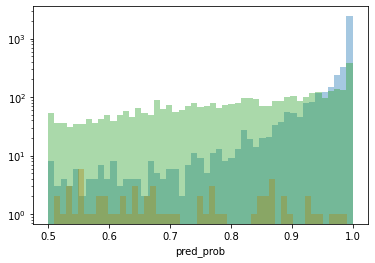

In [34]:


import seaborn as sns
#KfoldCVpredictions['pred_prob'].plot.hist(bins=50, grid= True,title = 'prediction probabilities' )


df1 = KfoldCVpredictions[KfoldCVpredictions['pred_correct'] == True]
fig = sns.distplot(df1['pred_prob'],  kde=False, label='correct predictions', bins = 49)
df2 = KfoldCVpredictions[KfoldCVpredictions['pred_correct'] == False]
fig = sns.distplot(df2['pred_prob'],  kde=False, label='False predictions', bins = 49)
fig = sns.distplot([max(i) for i in clf.predict_proba(df_unknown.drop(columns=['sequence','type']))],  kde=False, label='unknown', bins = 49)




fig.set_yscale('log')

In [167]:
#save_pickle(KfoldCVpredictions,'picklejar/10foldCVpredictions_SecVecEmbeddings.pickle')
#KfoldCVpredictions=read_pickle('picklejar/10foldCVpredictions_SecVecEmbeddings.pickle')
#KfoldCVpredictions.set_index('upi')
#with open('picklejar/10foldCVpredictions_SecVecEmbeddings.csv', 'w') as f:
#            KfoldCVpredictions.set_index('upi').to_csv(f)
list(KfoldCVpredictions.set_index('upi').index)


['UPI000005CB7F',
 'UPI000005D474',
 'UPI000009B40C',
 'UPI000009B74C',
 'UPI000009B8E6',
 'UPI000009B938',
 'UPI000009BD64',
 'UPI000009BF5F',
 'UPI000009C4CC',
 'UPI000012563A',
 'UPI000012EA37',
 'UPI000012EA43',
 'UPI0000136BE1',
 'UPI000019203B',
 'UPI00001B3F19',
 'UPI00001CE275',
 'UPI000021CB6A',
 'UPI0000358DA9',
 'UPI000044CD48',
 'UPI000048EF19',
 'UPI00004C9820',
 'UPI0000505C44',
 'UPI0000505C45',
 'UPI00006C2043',
 'UPI0000E0DA6C',
 'UPI0000EA272B',
 'UPI0000F350AC',
 'UPI0000F597CF',
 'UPI00015A1EF9',
 'UPI00015A3731',
 'UPI000162F2AB',
 'UPI0001710918',
 'UPI0001710936',
 'UPI00017304D2',
 'UPI00017992C0',
 'UPI00017F8C9D',
 'UPI0001814951',
 'UPI000189C150',
 'UPI000198878E',
 'UPI00019D95C1',
 'UPI0001A52368',
 'UPI0001B07E66',
 'UPI0001B5B242',
 'UPI0001B62F65',
 'UPI0001BEF40C',
 'UPI0001CB27DC',
 'UPI0001DDCF7D',
 'UPI0001E16105',
 'UPI0001F1F845',
 'UPI0001F3A50F',
 'UPI0001F3A523',
 'UPI0001F65923',
 'UPI000201BE9F',
 'UPI000201C2C5',
 'UPI000201F43E',
 'UPI00021

In [36]:
importance_df = pd.DataFrame(clf.feature_importances_, index=X.columns, 
                      columns=["Importance"])
print(importance_df.nlargest(20, columns=["Importance"]))
print(importance_df)


     Importance
795    0.041359
776    0.026857
535    0.023576
173    0.020141
879    0.019692
882    0.018628
580    0.018219
940    0.018107
70     0.017758
582    0.017057
454    0.016366
589    0.016201
868    0.016117
677    0.014087
572    0.013522
890    0.013044
685    0.013014
442    0.012805
223    0.012725
489    0.011932
      Importance
0       0.000073
1       0.000052
2       0.001101
3       0.000048
4       0.000046
...          ...
1019    0.000487
1020    0.000030
1021    0.000128
1022    0.000171
1023    0.000116

[1024 rows x 1 columns]


# Update type of the entries that were classified by the annotation approach, but did not match the type predicted by the 10-fold CV model

In [37]:
c = 0
for index, row in KfoldCVpredictions.iterrows():
    upi = row['upi']
    if row['true_val'] != row['pred_val']:
        c += 1
        TYPE = row['true_val']
        PROB = round(1.0 - row['pred_prob'],2)*100
        print(upi, upi2acc[upi], '\t', upi2typesource[upi], '\t', row['true_val'],row['pred_val'] )
        """if upi2typesource[upi] == 'domains':
            print(upi2typematch[upi], '\t', upi2doms[upi], '\n')
        else:
            print(upi2typematch[upi], '\t', upi2ann[upi][upi2typesource[upi]], '\n')"""
    else:
        TYPE = row['true_val']
        PROB = row['pred_prob']*100
    
    for acc in upi2acc[upi]:
        update_type = ("UPDATE phalp.UniProt SET UniProt.type=%s, UniProt.type_probability=%s, UniProt.type_evidence=%s WHERE UniProt.UniProt_ID  = %s;")
        cursor.execute(update_type,(TYPE,PROB, '%s annotation'%(upi2typesource[upi]),acc))
        cnx.commit()

UPI000009C4CC ['A0A0B5A4X8', 'H8ZM03', 'Q8H9R6'] 	 Protein name 	 VAL endolysin
UPI0000136BE1 ['P19897'] 	 UniProt location 	 VAL endolysin
UPI0001710936 ['B1GS47'] 	 Protein name 	 VAL endolysin
UPI0002AB0825 ['A0A097EYH3', 'A0A2Z5HAR7', 'A0A4Y6E6W7', 'L7TQG0'] 	 Protein name 	 VAL endolysin
UPI00065F620A ['A0A0H4TGB4'] 	 Protein name 	 VAL endolysin
UPI0006BD0C0C ['A0A0K0NL58'] 	 Protein name 	 VAL endolysin
UPI000744A942 ['A0A0U4B782', 'A0A0U4IQ42'] 	 Protein name 	 VAL endolysin
UPI0009320997 ['A0A1L2CUW3'] 	 Protein name 	 VAL endolysin
UPI000B57D3DB ['A0A1Y0T042'] 	 Protein name 	 VAL endolysin
UPI000EB761C0 ['A0A385EFA9'] 	 Protein name 	 VAL endolysin
UPI0001FC2585 ['A0A240EWB5', 'A0A2D0YEX2', 'A0A2D0YTL9', 'A0A2D0YUK8', 'A0A2D0YVC2', 'A0A2D0Z2J5', 'A0A385EGU1', 'A0A385EIE7', 'F1D1N1', 'F1D2A7', 'F1D2Y4', 'F1D3K8', 'F1D3U2', 'F1D4W4', 'F1D5J4', 'F1D671'] 	 Protein name 	 VAL endolysin
UPI0003BC174E ['U5PW80'] 	 Protein name 	 endolysin VAL
UPI0006A2962D ['A0A0K1LM21'] 	 Protein

,upi,true_val,pred_val,pred_prob,pred_correct
0,UPI000005CB7F,VAL,VAL,1.00,1.0
1,UPI000005D474,VAL,VAL,1.00,1.0
2,UPI000009B40C,endolysin,endolysin,0.97,1.0
3,UPI000009B74C,VAL,VAL,0.97,1.0
4,UPI000009B8E6,endolysin,endolysin,1.00,1.0
...,...,...,...,...,...
4091,UPI00116533EB,endolysin,endolysin,0.98,1.0
4092,UPI0011657157,endolysin,endolysin,0.87,1.0
4093,UPI0011658A6C,endolysin,endolysin,0.96,1.0
4094,UPI0011659750,VAL,VAL,0.97,1.0


In [139]:
df_known = df.loc[df['type']!='None']
df_unknown = df.loc[df['type']=='None']
X=df_known.drop(columns=['sequence','type'])
y=df_known['type']
clf = RandomForestClassifier(n_estimators=100 , class_weight = 'balanced')
clf.fit(X, y)
df_unknown['type'] = clf.predict(df_unknown.drop(columns=['sequence','type']))
df_unknown['type_probability'] = [max(i) for i in clf.predict_proba(df_unknown.drop(columns=['sequence','type']))]
for upi, row in df_unknown.iterrows():
    TYPE = row['type']
    PROB = row['type_probability']*100
    for acc in upi2acc[upi]:
        update_type = ("UPDATE phalp.UniProt SET UniProt.type=%s, UniProt.type_probability=%s, UniProt.type_evidence=%s WHERE UniProt.UniProt_ID  = %s;")
        cursor.execute(update_type,(TYPE,PROB,'ML prediction',acc))
        cnx.commit()


/home/bjornc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/bjornc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


DatabaseError: 2006 (HY000): MySQL server has gone away

In [47]:
save_pickle(clf,'picklejar/RF_clf_SeqVecEmbeddings_trained.pickle')
#clf=read_pickle('picklejar/RF_clf_SeqVecEmbeddings_trained.pickle')

In [48]:
os.system("mysqldump -u %s -p%s -h %s  --no-tablespaces %s CDSs domains EC experimental_evidence gene_ontologies hosts link_EC_UniProt link_phage_host link_UniRef_domains phages sequence_conflicts tertiary_structures UniProt UniRef  > %s.sql" % (user,password,host,db,'/var/www/html/phalp/djangodir/static/PhaLP/dumps/PhaLP_dump_v2019_10'))



0